# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S4

## Panel A

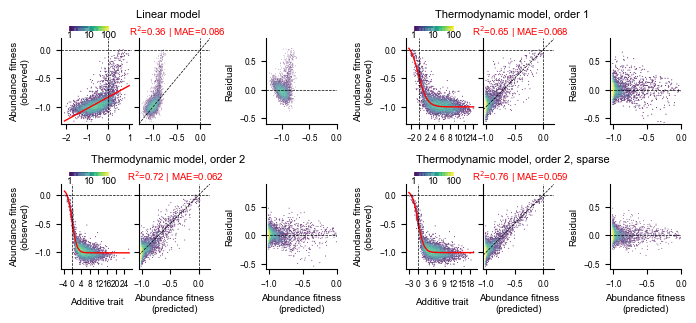

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from seaborn import kdeplot
from matplotlib.ticker import MaxNLocator

def sigmoid(x, L ,x0, k, b): ##https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    z = L / (1 + np.exp(-k*(x-x0))) + b
    return (z)
    
def normalize(values, bounds):
        return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

model_names = {'linear': 'Linear', 'order1':'1', 'order2':'2', '2_sparse_regularized':'2'}
tasks = {'linear': '1', 'order1':'1', 'order2':'1', '2_sparse_regularized':'4'}
model_title = {'linear': 'Linear model', 'order1':'Thermodynamic model, order 1', 'order2':'Thermodynamic model, order 2', '2_sparse_regularized':'Thermodynamic model, order 2, sparse'}

model_xlims={'linear':[-1.3,0.2], 'order1':[-1.05,0.2],'order2':[-1.05,0.2],'2_sparse_regularized':[-1.05,0.2]}
res_xlims = {'linear':[-1.3,0], 'order1':[-1.05,0],'order2':[-1.05,0],'2_sparse_regularized':[-1.05,0]}
model_ylims={'linear':[-1.3,0.2], 'order1':[-1.3,0.2],'order2':[-1.3,0.2],'2_sparse_regularized':[-1.3,0.2]}
model_ticks={'linear':1, 'order1':2,'order2':4,'2_sparse_regularized':3}

fig = plt.figure(figsize=(8, 3))
outer = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.7)

for lib_idx, dataset in enumerate(list(model_names.keys())):
    
    # --- Define the position in the big figure ---
    inner = gridspec.GridSpecFromSubplotSpec(
        1, 4,  # 4 stacked subplots
        subplot_spec=outer[lib_idx],
        width_ratios=[1,1,0.6,1],
        hspace=0.15,
        wspace=0.1
    )

    ################################
    #  LOAD PHENOTYPE PREDICTIONS  #
    ################################
    
    if dataset != '2_sparse_regularized':
        predicted_phenotypes = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+dataset+'/task_'+tasks[dataset]+'/predictions/predicted_phenotypes_all.txt',
                                          sep='\t', lineterminator='\n',low_memory=False)
    else:
        predicted_phenotypes = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_order'+dataset+'/task_'+tasks[dataset]+'/predictions/predicted_phenotypes_all.txt',
                                          sep='\t', lineterminator='\n',low_memory=False)
    
    predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
    
    mask = predicted_phenotypes['WT'] != True
    predicted_phenotypes.loc[mask, 'predicted_fitness'] = predicted_phenotypes.loc[mask].apply(lambda row: row['fold_' + str(int(row['Fold']))],axis=1)

    # Normalize data in the -1 to 0 range
    
    
    reference=predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['core']
        
    norm_fig = plt.figure(figsize=(0,0))
    lines = kdeplot(data=predicted_phenotypes,x='fitness',linewidth=0).get_lines()
    for line in lines:
        x, y = line.get_data()
        mode=(x[np.argmax(y)])
    plt.close()
    
    predicted_phenotypes['fitness']=normalize(list(predicted_phenotypes['fitness']),{'actual': {'lower': mode, 'upper': predicted_phenotypes.loc[predicted_phenotypes['core']==reference]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

    norm_fig = plt.figure(figsize=(0,0))
    lines = kdeplot(data=predicted_phenotypes,x='predicted_fitness',linewidth=0).get_lines()
    for line in lines:
        x, y = line.get_data()
        mode=(x[np.argmax(y)])
    plt.close()
    
    predicted_phenotypes['predicted_fitness']=normalize(list(predicted_phenotypes['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

    
    ####################################
    #  PLOT FITNESS VS ADDITIVE TRAIT  #
    ####################################

    ax0 = plt.Subplot(fig, inner[0])
    fig.add_subplot(ax0)

    ax1 = plt.Subplot(fig, inner[1],sharey=ax0)
    fig.add_subplot(ax1)
    
    ax2 = plt.Subplot(fig, inner[3])
    fig.add_subplot(ax2)

    
    predicted_phenotypes=predicted_phenotypes.sort_values(['mean_additive_trait'])
    
    
    if model_names[dataset]=='Linear':
        x=predicted_phenotypes[['mean_additive_trait']].to_numpy()
        y=predicted_phenotypes[['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x, y)
        
        y_pred = model.predict(x)
        r2 = r2_score(y,y_pred)
        r,p = pearsonr(y.ravel(),y_pred.ravel())
        hbin=ax0.hexbin(predicted_phenotypes['mean_additive_trait'],predicted_phenotypes['fitness'],bins='log',gridsize=75, cmap='viridis',rasterized=True,linewidths=0, vmax=100)
        ax0.plot(x, y_pred, '-',c='r', linewidth=1)
    else:
        x=predicted_phenotypes['mean_additive_trait']
        y=predicted_phenotypes['fitness']
        p0 = [max(y), np.median(x),0,min(y)] # this is an mandatory initial guess
        popt, pcov = curve_fit(sigmoid, x, y,p0, method='lm', maxfev=10000)
        x_range = np.linspace(x.iloc[0],x.iloc[-1],1000)
        y_sig = sigmoid(x_range, *popt)
        deriv = np.diff(y_sig)/np.diff(x_range)
        hbin=ax0.hexbin(predicted_phenotypes['mean_additive_trait'],predicted_phenotypes['fitness'],bins='log',gridsize=75, cmap='viridis',rasterized=True,linewidths=0, vmax=100)
        ax0.plot(x_range, y_sig, '-',c='r', linewidth=1)
    
    ax0.axvline(0, ls='--', color='black', linewidth=0.5)
    ax0.axhline(0,  ls='--', color='black', linewidth=0.5)
    ax0.set_xlabel('Additive trait', fontsize=7,labelpad=6.5)
    ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
    ax0.tick_params(axis='y', labelsize=6)
    ax0.xaxis.set_major_locator(MultipleLocator(model_ticks[dataset]))
    ax0.tick_params(axis='x', labelsize=6,rotation=0)
    ax0.set_yticks(np.arange(-2,1,0.5))
    #ax0.set_ylim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax0.set_ylim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax0.set_rasterization_zorder(0)
    ax0.spines[['top','right']].set_visible(False)
    fmt = '%1.f'


    # Get positions
    bbox0 = ax0.get_position()
    bbox1 = ax1.get_position()
    
    # Create a colorbar axis centered between ax0 and ax1
    cbar_left = bbox0.x0 + 0.01
    cbar_bottom = bbox0.y1 + 0.025   # a little bit above
    cbar_width = 0.05
    cbar_height = 0.015              # small height for horizontal colorbar
    
    cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
    
    # Now create colorbar in the dynamic cax
    cb = fig.colorbar(hbin, ax=ax0, cax=cax, orientation='horizontal')
    cb.outline.set_visible(False)
    cb.ax.tick_params(axis='x', which='both', direction='in', color='white', width=0.25, labelsize=6)
    cb.ax.xaxis.set_tick_params(pad=0)
    cb.set_ticks([1,10,100])
    cb.set_ticklabels([1,10,100], fontsize=7)
    
    
    ########################################
    #  PLOT OBSERVED VS PREDICTED FITNESS  #
    ########################################
    
    y = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['fitness']].to_numpy()
    x = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    
    #fig, ax = plt.subplots(figsize=(1,1))
    hbin=ax1.hexbin(x=predicted_phenotypes['predicted_fitness'].loc[predicted_phenotypes['Nham_aa']>0],y=predicted_phenotypes['fitness'].loc[predicted_phenotypes['Nham_aa']>0],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)
    ax1.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    
    
    ax1.axvline(0, ls='--', color='black', lw=0.5)
    ax1.axhline(0, ls='--', color='black', lw=0.5)
    ax1.text(model_xlims[dataset][0]-0.2,0.25,'\nR$^2$='+str(round(r2_score(y,y_pred),2))+' | MAE='+str(round(mean_absolute_error(y,y_pred),3)),fontsize=7, color='r')
    ax1.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    ax1.set_ylabel('', fontsize=7)
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks(np.arange(-2,1,0.5))
    ax1.tick_params(axis='x', labelsize=6,rotation=0)
    ax1.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax1.set_yticks(np.arange(-2,1,0.5))
    ax1.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax1.set_ylim(model_ylims[dataset][0],model_ylims[dataset][1])
    #ax.set_xlim(-1.7,0.2)
    #ax.set_yticks(np.arange(-4,1,1))
    ax1.set_rasterization_zorder(0)
    ax1.spines[['top','right']].set_visible(False)

    ####################
    #  PLOT RESUDIALS  #
    ####################

    residual = (y - y_pred)
    
    hbin=ax2.hexbin(x=predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['predicted_fitness']].to_numpy(),y=residual,bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)

    ax2.axhline(0, ls='--', color='black', lw=0.5)
    ax2.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    ax2.set_ylabel('Residual', fontsize=7)
    ax2.tick_params(axis='y', labelsize=6)
    ax2.set_xticks(np.arange(-2,1,0.5))
    ax2.tick_params(axis='x', labelsize=6,rotation=0)
    ax2.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax2.set_yticks(np.arange(-2,2,0.5))
    ax2.set_ylim(-0.6,0.9)
    ax2.set_xlim(res_xlims[dataset][0],res_xlims[dataset][1])
    #ax1.set_ylim(model_ylims[dataset][0],model_ylims[dataset][1])
    #ax.set_xlim(-1.7,0.2)
    #ax.set_yticks(np.arange(-4,1,1))
    ax2.set_rasterization_zorder(0)
    ax2.spines[['top','right']].set_visible(False)
    
    ax0.set_title(model_title[dataset], fontsize=8, x=1.5,pad=15)

    # Which column and row?
    is_left_col = (lib_idx % 2 == 0)
    is_bottom_row = (lib_idx // 2 == 1)
    
    # Y-labels and Y-ticks
    if is_left_col:
        ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
        ax0.tick_params(axis='y', labelsize=6)
        ax1.tick_params(labelleft=False)  # Hide only the ticks, but leave ax0 intact
        ax2.tick_params(labelleft=True)  # Hide only the ticks, but leave ax0 intact
    else:
        ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
        ax0.tick_params(axis='y', labelsize=6)
        ax1.tick_params(labelleft=False)  # Hide ticks on ax1
        ax2.tick_params(labelleft=True)  # Hide ticks on ax1
    
    # X-labels
    if is_bottom_row:
        ax0.set_xlabel('Additive trait', fontsize=7, labelpad=6.5)
        ax1.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
        ax2.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    else:
        ax0.set_xlabel('')
        ax1.set_xlabel('')
        ax2.set_xlabel('')
#    ax0.text(0.02, 0.02, f'n={len(predicted_phenotypes):,}', transform=ax0.transAxes, fontsize=8, va='bottom', ha='left')

plt.show()

## Panel B

In [4]:
# Discard nth percentile with highest errors
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
import seaborn as sns
import pandas as pd

quantile = 1

ci2a_overall_full_model_performance = pd.DataFrame()
ci2a_model_performance_by_nham=pd.DataFrame()
ci2a_overall_sparse_model_performance=pd.DataFrame()
ci2a_sparse_model_performance_by_nham=pd.DataFrame()

model_names = {'linear': 'Linear', 'order1':'1', 'order2':'2', 'order2_sparse_regularized':'2'}
tasks = {'linear': '1', 'order1':'1', 'order2':'1', 'order2_sparse_regularized':'4'}

for mochi_model in model_names.keys():

    # Load predictions
    predicted_phenotypes = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+mochi_model+'/task_'+tasks[mochi_model]+'/predictions/predicted_phenotypes_all.txt',
                                          sep='\t', lineterminator='\n', low_memory=False)
    
    RT=303*0.001987
    predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
    predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)
    
    predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
    predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)
    
    predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
    predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT
    
    for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
        predicted_phenotypes.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
        predicted_phenotypes.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

    predicted_phenotypes_scaled = predicted_phenotypes[predicted_phenotypes['sigma'] <= predicted_phenotypes['sigma'].quantile(quantile)].copy()

    # calculate overall performance
    y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['fitness']].to_numpy()
    x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']>0][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)

    if mochi_model != 'order2_sparse_regularized':
        ci2a_overall_full_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)
    else:
        ci2a_overall_sparse_model_performance.at[model_names[mochi_model],'All']=round(r2_score(y,y_pred),2)

    # calculate performance per nham
    for hamm_dist in range(1,8,1):    
        y = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['fitness']].to_numpy()
        x = predicted_phenotypes_scaled.loc[predicted_phenotypes_scaled['Nham_aa']==hamm_dist][['predicted_fitness']].to_numpy()
        
        model = LinearRegression()
        model.fit(x,y)
        y_pred = model.predict(x)
        
        if mochi_model != 'order2_sparse_regularized':
            ci2a_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)
        else:
            ci2a_sparse_model_performance_by_nham.at[model_names[mochi_model],hamm_dist]=round(r2_score(y,y_pred),2)

In [5]:
cummulative_sigma = 0
for index, row in predicted_phenotypes.loc[predicted_phenotypes['WT']!=True].iterrows():
    cummulative_sigma = cummulative_sigma + (row.sigma**2)

MEV = predicted_phenotypes.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(predicted_phenotypes.index))
all_order_FEV = MEV/predicted_phenotypes.var(numeric_only=True)['fitness']

FEV_correction = pd.DataFrame()
for nham in range(1,8,1):
    nham_vars = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']==nham]
    
    cummulative_sigma = 0
    for index, row in nham_vars.iterrows():
        cummulative_sigma = cummulative_sigma + (row.sigma**2)
    
    MEV = nham_vars.var(numeric_only=True)['fitness'] - (cummulative_sigma/len(nham_vars.index))
    FEV = MEV/nham_vars.var(numeric_only=True)['fitness']
    FEV_correction.at[0,nham]=FEV

In [6]:
full_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

models = {'linear':'Linear',
         'order1':'1',
         'order2':'2',
         'order2_sparse_regularized':'2'}

for model in list(model_names.keys())[:-1]:
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+model+'/task_'+tasks[model]+'/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    full_models_terms_by_order[models[model]]=coefs['order'].value_counts()


sparse_models_terms_by_order = pd.DataFrame(index=np.arange(1,3,1))

for model in list(model_names.keys())[-1:]:
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+model+'/task_'+tasks[model]+'/weights/weights_Folding.txt',
                       sep='\t')
    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        coefs.at[index,'order']=len(row.id.split('_'))
    sparse_models_terms_by_order[models[model]]=coefs['order'].value_counts()


In [7]:
ci2a_model_performance_by_nham

,1,2,3,4,5,6,7
Linear,0.85,0.40,0.56,0.45,0.32,0.21,0.13
1,0.87,0.86,0.76,0.74,0.52,0.28,0.08
2,0.34,0.92,0.83,0.81,0.63,0.41,0.18


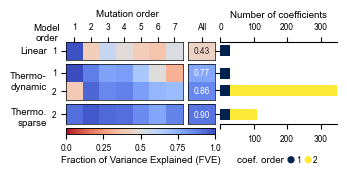

In [8]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

fig, ax = plt.subplot_mosaic([['top left', 'top centre', 'top right'],
                              ['biophys left', 'biophys centre', 'biophys right'],
                              ['middle left', 'middle centre', 'middle right'],
                              ['bottom left-centre', 'bottom left-centre', 'bottom right']],
                            width_ratios = [3, 0.7, 3],
                            height_ratios = [0.33, 0.67 ,0.37,0.1],
                            figsize=(3.5,1.2))

sns.heatmap(ci2a_model_performance_by_nham.iloc[0:1].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(ci2a_model_performance_by_nham.iloc[1:].divide(FEV_correction.loc[0],axis=1), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5, cbar=False)
sns.heatmap(ci2a_sparse_model_performance_by_nham.divide(FEV_correction.loc[0],axis=1).apply(pd.to_numeric), annot=False, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle left'], linewidths=0, linecolor='black', annot_kws={'color':'black', 'font':'Arial', 'size':6}, center=0.5,cbar_ax=ax['bottom left-centre'],cbar_kws={"orientation": "horizontal", 'location':'bottom'})

#ax['top left'].set_xlabel('Mutation order', fontsize=7)
# Setting y-tick labels explicitly to ensure visibility
ax['top left'].set_xticks([i+0.5 for i in range(ci2a_model_performance_by_nham.shape[1])])
ax['top left'].set_xticklabels(ci2a_model_performance_by_nham.columns, fontsize=6, rotation=0)
ax['top left'].set_yticks([0.5])
ax['top left'].set_yticklabels(['1'], fontsize=6, rotation=0)
ax['top left'].xaxis.set_label_position('top')
ax['top left'].xaxis.set_ticks_position('top')
ax['top left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_yticks([i+0.5 for i in range(ci2a_sparse_model_performance_by_nham.shape[0])])
ax['middle left'].set_yticklabels([str(i+2) for i in range(ci2a_sparse_model_performance_by_nham.shape[0])], fontsize=6, rotation=0)
ax['middle left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['middle left'].set_xticks(ticks=[])
ax['biophys left'].set_yticks([i+0.5 for i in range(ci2a_model_performance_by_nham.shape[0]-1)])
ax['biophys left'].set_yticklabels([str(i+1) for i in range(ci2a_model_performance_by_nham.shape[0]-1)], fontsize=6, rotation=0)
ax['biophys left'].tick_params(axis='both',labelsize=6, labelrotation=0)
ax['biophys left'].set_xticks(ticks=[])
ax['bottom left-centre'].set_xticks(ticks=np.arange(0,1.25,.25),labels=np.arange(0,1.25,.25), fontsize=6)
ax['bottom left-centre'].set_xlabel('Fraction of Variance Explained (FVE)', rotation=0, labelpad=2, fontsize=7)

sns.heatmap(ci2a_overall_full_model_performance.iloc[0:1]/all_order_FEV, annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['top centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['top centre'].set_yticks(ticks=[])
ax['top centre'].set_xticks([i+0.5 for i in range(ci2a_overall_full_model_performance.shape[1])])
ax['top centre'].set_xticklabels(ci2a_overall_full_model_performance.columns, fontsize=6, rotation=0)
ax['top centre'].xaxis.set_label_position('top')
ax['top centre'].xaxis.set_ticks_position('top')
ax['top centre'].tick_params(axis='both',labelsize=6, labelrotation=0)

sns.heatmap((ci2a_overall_full_model_performance.iloc[1:]/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['biophys centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['biophys centre'].set_yticks(ticks=[])
ax['biophys centre'].set_xticks(ticks=[])

sns.heatmap((ci2a_overall_sparse_model_performance/all_order_FEV), annot=True, fmt=".2f", cmap='coolwarm_r', vmin=0, vmax=1,ax=ax['middle centre'], linewidths=0, linecolor='black', annot_kws={'ha': 'center', 'va': 'center','font':'Arial', 'size':6}, center=0.5, cbar=False)
ax['middle centre'].set_yticks(ticks=[])
ax['middle centre'].set_xticks(ticks=[])

full_models_terms_by_order.T.iloc[0:1].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['top right'], legend=False, width=0.65)
ax['top right'].invert_yaxis()
ax['top right'].spines[['right','bottom','left']].set_visible(False)
ax['top right'].xaxis.set_label_position('top')
ax['top right'].xaxis.set_ticks_position('top')
ax['top right'].set_xlabel('Number of coefficients', fontsize=7)
ax['top right'].set_yticks(ticks=np.arange(0,1,1), labels=[])
ax['top right'].set_xticks(ticks=np.arange(0,400,100),labels=np.arange(0,400,100))
ax['top right'].set_xlim(0,350)
ax['top right'].tick_params(axis='both',labelsize=6, labelrotation=0)

full_models_terms_by_order.T.iloc[1:].plot(kind='barh', stacked=True, cmap='cividis', ax=ax['biophys right'], legend=False, width=0.65)
ax['biophys right'].invert_yaxis()
ax['biophys right'].spines[['right','bottom','left','top']].set_visible(False)
ax['biophys right'].set_yticks(ticks=np.arange(0,2,1), labels=[])
ax['biophys right'].set_xticks(ticks=[],labels=[])
ax['biophys right'].set_xlim(0,350)
ax['biophys right'].tick_params(axis='both',labelsize=6, labelrotation=0)

sparse_models_terms_by_order.T.plot(kind='barh', stacked=True, cmap='cividis', ax=ax['middle right'], legend=False, width=0.6)
ax['middle right'].invert_yaxis()
handles, labels = ax['middle right'].get_legend_handles_labels()
ax['middle right'].spines[['right','top','left']].set_visible(False)
ax['middle right'].set_yticks(ticks=np.arange(0,1,1),labels=[])
ax['middle right'].set_xticks(ticks=np.arange(0,400,100),labels=['']+[str(i) for i in np.arange(100,400,100)], fontsize=6)
ax['middle right'].set_xlim(0,350)
ax['middle right'].xaxis.set_ticks_position('bottom')

for axis in ['top left', 'biophys left', 'middle left', 'bottom left-centre', 'top centre', 'biophys centre', 'middle centre']:
    for spine in ax[axis].spines.values():
        spine.set(visible=True,lw=0.5,edgecolor='black')

ax['bottom right'].axis('off')
#legend = ax['bottom right'].legend(handles, labels, title='Coefficient order', ncol=2, frameon=False, fontsize=6, bbox_to_anchor=(0.85,-1.5))
#legend.get_title().set_fontsize('7')
 

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a circle artist
        center = (width / 2, height / 2)
        p = mpatches.Circle(center, radius=min(width, height) / 2, color=orig_handle.get_facecolor())
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# Define circular patches for each legend handle
circle_handles = [mpatches.Circle((0, 0), radius=3, color=h.patches[0].get_facecolor()) for h in handles]

# Set 'coef. order' as a pseudo-title inline with labels
legend_labels = ['coef. order'] + labels
blank_patch = mpatches.Circle((0, 0), radius=0, color='none')  # Invisible patch for title alignment
circle_handles = [blank_patch] + circle_handles

# Create the legend with custom circular handles and compact layout
legend = ax['bottom right'].legend(circle_handles, legend_labels,
                                   handler_map={mpatches.Circle: HandlerCircle()},  # Use custom circle handler
                                   ncol=3,  # Layout in columns
                                   frameon=False, fontsize=6,
                                   loc='lower center',  # Align legend below the figure
                                   bbox_to_anchor=(0.45, -7),  # Adjust if needed
                                   handletextpad=0.2,  # Reduced spacing between handle and label
                                   labelspacing=0.2,  # Reduced spacing between labels
                                   handlelength=0.8,  # Shorten handle length
                                   columnspacing=0.5)  # Reduced space between columns

# Adjust font size of the "pseudo-title" if necessary
legend.get_texts()[0].set_fontsize(7)


for plot_name, df in zip(['top right', 'biophys right', 'middle right'],
                         [full_models_terms_by_order.T.iloc[0:1],
                          full_models_terms_by_order.T.iloc[1:],
                          sparse_models_terms_by_order.T]):
    totals = df[2]
    
    for i, total in enumerate(totals):
        # Annotate total number of coefficients for all rows except the last row in the last plot
        if not (plot_name == 'middle right' and i == len(totals) - 1):
            try:
                continue
#                ax[plot_name].text(total +30, i, f"{int(total)}",  # Adjust 5 for spacing
#                                   ha='left', va='center', fontsize=6, color='black')
            except ValueError:
                continue
        
    # Add combined total and percentage annotation for the last row of the last DataFrame
    if plot_name == 'middle right':
        # Calculate the total for the last row of the last and penultimate DataFrames
        last_total = totals.iloc[-1]
        penultimate_total = full_models_terms_by_order.T.iloc[1:].sum(axis=1).iloc[-1]
        
        # Calculate percentage based on the last row of the penultimate df
        percentage = (last_total / penultimate_total) * 100 if penultimate_total != 0 else 0
        
        # Annotate with total and percentage for the last row only
#        ax[plot_name].text(last_total +20, len(totals) - 1, f"{int(last_total)} ({percentage:.1f}%)",
#                           ha='left', va='center', fontsize=6, color='black')



fig.text(0.3, 1.09, 'Mutation order', ha='center', fontsize=7)
fig.text(0.07, 0.89, 'Model\norder', ha='center', fontsize=7)
fig.text(0.07, 0.8, 'Linear', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.55, 'Thermo-\ndynamic', va='center', ha='right', rotation='horizontal', fontsize=7)
fig.text(0.07, 0.25, 'Thermo.\nsparse', va='center', ha='right', rotation='horizontal', fontsize=7)

plt.subplots_adjust(hspace=0.2, wspace= 0.06)


## Panel C

#### Rocklin mining

In [9]:
import pandas as pd
rocklin = pd.read_csv(path+"Fig3/Tsuboyama2023_Dataset1_20230416.csv")

In [10]:
# Definitions

P01053 = 'AAAACTGAATGGCCAGAATTGGTTGGTAAATCTGTCGAAGAAGCAAAAAAAGTTATCTTGCAAGATAAACCAGAAGCACAAATCATTGTTTTGCCAGTTGGTACTATTGTTACTATGGAATATAGAATTGATAGAGTCAGATTGTTTGTCGATAAATTGGATAATATCGCACAAGTTCCAAGAGTTGGT'

cores = {'P01053' : [11,18,27,45,47,49,55]}

In [11]:
from Bio.Seq import Seq
import math

query_protein='P01053'
pdb='3CI2'
DTS = ['F', 'L', 'I', 'V', 'M']

for index, row in rocklin[rocklin['name'].str.startswith(pdb)].iterrows():
    if len(row['name'].split('_'))>1:
        if row['name'].split('_')[1]=='scramble':
            rocklin.at[index,'scramble']=True

query_protein_wt = str(Seq(P01053).translate())
rocklin_query_protein = rocklin[rocklin['name'].str.startswith(pdb)].loc[rocklin['scramble']!=True].copy()

fyn_wt = str(Seq(rocklin_query_protein.loc[rocklin_query_protein['name']==pdb+'.pdb'].iloc[0]['dna_seq']).translate())[4:-5]

def translate(sequence):
    variant = str(Seq(sequence).translate())
    if variant.find('SAGGSAGG') > -1:
        variant = variant[8:-9]
    else:
        variant = variant[4:-5]
    return variant

def find_mutations(sequence, wt_seq):
    mutations = []
    for i, (wt_res, seq_res) in enumerate(zip(wt_seq, sequence), start=1):
        if wt_res != seq_res:
            mutations.append(f"{wt_res}{i}{seq_res}")
    return ",".join(mutations)

def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))


rocklin_query_protein['aa_seq'] = rocklin_query_protein['dna_seq'].apply(lambda seq: translate(seq))
rocklin_query_protein['mutations'] = rocklin_query_protein['aa_seq'].apply(lambda seq: find_mutations(seq, fyn_wt))
rocklin_query_protein['Nham'] = rocklin_query_protein['aa_seq'].apply(lambda seq: hamming_distance(seq, fyn_wt))
rocklin_query_protein["redundant_single"] = pd.Series(dtype="object") 
for index, row in rocklin_query_protein.iterrows():
    if row.Nham==1 and len(row['name'].split('_'))>2:
        rocklin_query_protein.at[index,'redundant_single']=True
    else:
        rocklin_query_protein.at[index,'redundant_single']=False
rocklin_query_protein

/tmp/15462475/ipykernel_1640530/918143266.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rocklin.at[index,'scramble']=True


,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,deltaG_95CI_high,deltaG_95CI_low,deltaG_95CI,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,scramble,aa_seq,mutations,Nham,redundant_single
285944,3CI2.pdb,TCCGCGGGTGGTAAAACCGAGTGGCCGGAACTCGTTGGTAAATCTG...,0.343690,0.380894,0.286983,0.093910,0.075632,-1.214724,2.069063,2.120465,...,1.869930,1.683263,0.186668,0.343689978238626,-1.0702290762480935,NaN,KTEWPELVGKSVEEAKKVILQDKPEAQIIVLPVGTIVTMEYRIDRV...,,0,False
285945,3CI2.pdb_A15D,TCTGCTGGCGGTAAAACCGAATGGCCGGAACTCGTTGGTAAATCTG...,-0.852718,-0.827540,-0.865005,0.037465,0.047857,-1.180366,0.069300,0.131241,...,0.114904,-0.003751,0.118656,-0.8527178352954407,-1.9443872429792528,NaN,KTEWPELVGKSVEEDKKVILQDKPEAQIIVLPVGTIVTMEYRIDRV...,A15D,1,False
285946,3CI2.pdb_A15E,TCCGCTGGCGGTAAGACCGAATGGCCGGAACTCGTGGGTAAATCCG...,-0.788247,-0.767686,-0.821810,0.054124,0.055224,-1.185664,0.234305,0.279422,...,0.272261,0.204975,0.067286,-0.7882466102385011,-1.787273630395516,NaN,KTEWPELVGKSVEEEKKVILQDKPEAQIIVLPVGTIVTMEYRIDRV...,A15E,1,False
285947,3CI2.pdb_A15F,TCCGCGGGTGGTAAAACCGAATGGCCGGAACTGGTTGGCAAATCCG...,-0.609624,-0.573691,-0.637713,0.064022,0.065692,-1.227776,0.666126,0.728590,...,1.265173,1.095486,0.169687,-0.6096243713479558,-1.172503561426482,NaN,KTEWPELVGKSVEEFKKVILQDKPEAQIIVLPVGTIVTMEYRIDRV...,A15F,1,False
285948,3CI2.pdb_A15G,TCTGCGGGTGGTAAAACCGAATGGCCGGAACTCGTTGGCAAATCTG...,0.340137,0.387834,0.283370,0.104464,0.087235,-1.201642,2.046170,2.112120,...,1.861328,1.696652,0.164676,0.3401368926335868,-1.0468292845752674,NaN,KTEWPELVGKSVEEGKKVILQDKPEAQIIVLPVGTIVTMEYRIDRV...,A15G,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535191,3CI2.pdb_pross5,TCTGCTGGTGGTAAAACCGAATGGCCGGAACTGGTGGGTAAATCTG...,1.177145,1.244906,1.124841,0.120065,0.060897,-1.162877,3.150697,3.246487,...,2.858997,2.686686,0.172311,1.1771446729543324,-0.3024802137359607,NaN,KTEWPELVGKSVEEAKKVILQDNPEAQIIVLPVGTIVTMDYRCDRV...,"K23N,E40D,I43C,L53N,N55I",5,False
535192,3CI2.pdb_pross6,TCTGCTGGTGGTAAAACCGAATGGCCGGAACTGGTTGGTAAATCTG...,0.985990,1.087458,0.933320,0.154137,0.110130,-1.148907,2.864923,3.006167,...,2.638137,2.509507,0.128630,0.985989911341104,-0.382312561984066,NaN,KTEWPELVGKSVEEAKKVILQDNPEAQIIVLPEGTIVTMDYRCDRV...,"K23N,V33E,E40D,I43C,L53N,D54N,N55I,I56V",8,False
535193,3CI2.pdb_pross8,TCCGCGGGTGGCAAAACTGAGTGGCCGGAACTGGTTGGTAAATCTG...,0.962533,0.980714,0.913051,0.067663,0.084243,-1.147664,2.830723,2.855931,...,2.669768,2.477390,0.192378,0.9625330744403442,-0.4615365711976976,NaN,KTEWPELVGKSVEEAKKVILQDNPDAQIIVLPEGTIVTMDYRCDRV...,"K23N,E25D,V33E,E40D,I43C,L53N,D54N,N55I,I56V",9,False
535194,3CI2.pdb_pross9,TCTGCGGGTGGTAAAACTGAATGGCCGGAACTCGTTGGTAAATCTG...,1.250043,1.291941,1.190538,0.101403,0.064919,-1.151230,3.238164,3.297841,...,2.846804,2.749591,0.097213,1.2500432615739152,-0.3715953344166392,NaN,KTEWPELVGKSVEEAKKIILQDNPDADIIVLPEGTIVTMDYRCDRV...,"V18I,K23N,E25D,Q27D,V33E,E40D,I43C,L53N,D54N,N...",11,False


In [12]:
rocklin_query_protein.to_csv(path+'FigS4/CI-2A_Tsuboyama.txt',sep='\t')

#### Thermomut mining

In [13]:
import pandas as pd
import numpy as np

thermomut = pd.read_csv(path+"FigS4/CI-2A_thermomut.csv",skipfooter=1,engine='python')
for index, row in thermomut.iterrows():
    for param in ['ΔΔG','ΔTm']:
        if row[param]=="'-":
            thermomut.at[index,param]=np.nan
        elif row[param].startswith("'"):
            thermomut.at[index,param]=float(row[param][1:])
        else:
            thermomut.at[index,param]=float(row[param])
thermomut['ΔΔG']=-1*thermomut['ΔΔG']
thermomut

,ID,Protein Name,Mutation,PDB,UNIPROT,T,pH,Method,Measure,ΔΔG,ΔTm,Mutation Type,Depht of residue,Reference
0,1008,Subtilisin-chymotrypsin inhibitor-2A,R67A,2CI2,P01053,323.15,4.20,GdnHCl,Fluorescence,1.4,NaN,Single,2.7,PMID: 2207072
1,1530,Subtilisin-chymotrypsin inhibitor-2A,K21A,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,0.8,NaN,Single,2.01,PMID: 7490748
2,1531,Subtilisin-chymotrypsin inhibitor-2A,"K21A,E26A",2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,1.1,NaN,Multiple,'-,PMID: 7490748
3,1532,Subtilisin-chymotrypsin inhibitor-2A,K21M,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,0.7,NaN,Single,2.01,PMID: 7490748
4,1533,Subtilisin-chymotrypsin inhibitor-2A,P25A,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,-0.92,NaN,Single,2.08,PMID: 7490748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2525,Subtilisin-chymotrypsin inhibitor-2A,I76A,2CI2,P01053,298.15,6.30,GdnHCl,Fluorescence,4.17,NaN,Single,3.6,PMID: 8218191
159,2877,Subtilisin-chymotrypsin inhibitor-2A,I39L,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.96,NaN,Single,5.47,PMID: 8422372
160,2878,Subtilisin-chymotrypsin inhibitor-2A,R67A,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.21,NaN,Single,2.7,PMID: 8422372
161,2879,Subtilisin-chymotrypsin inhibitor-2A,I39V,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.17,NaN,Single,5.47,PMID: 8422372


In [14]:
relative_positions = {'PMID: 9819209' : -1,
                     'PMID: 11786916' : -1,
                     'PMID: 14556750' : -1,
                     'PMID: 12079394' : -1,
                     'PMID: 18626019' : -1,
                     'PMID: 16142914' : -84}
thermomut["mutations"] = pd.Series(dtype="object")
thermomut['Mut1'] = pd.Series(dtype="object")
thermomut['Mut2'] = pd.Series(dtype="object")
thermomut['Mut3'] = pd.Series(dtype="object")
for index, row in thermomut.iterrows():
    thermomut.at[index,'order']=len(row.Mutation.split(','))
    offset = -20
    for i in range(0,len(row.Mutation.split(','))):
        thermomut.at[index,'Mut'+str(i+1)]=row.Mutation.split(',')[i].replace(' ','')[0]+str(int(row.Mutation.split(',')[i].replace(' ','')[1:-1])+offset)+row.Mutation.split(',')[i][-1]
    thermomut.at[index,'mutations']=','.join(i.replace(' ','')[0]+str(int(i.replace(' ','')[1:-1])+offset)+i.replace(' ','')[-1] for i in row.Mutation.split(','))
    #thermomut.at[index,'Mut'+str(i+1)]=row.Mutation.split(',')[i][0]+str(int(row.Mutation.split(',')[1].replace(' ','')[1:-1])+offset)+row.Mutation.split(',')[1].replace(' ','')[-1]

thermomut

,ID,Protein Name,Mutation,PDB,UNIPROT,T,pH,Method,Measure,ΔΔG,ΔTm,Mutation Type,Depht of residue,Reference,mutations,Mut1,Mut2,Mut3,order
0,1008,Subtilisin-chymotrypsin inhibitor-2A,R67A,2CI2,P01053,323.15,4.20,GdnHCl,Fluorescence,1.4,NaN,Single,2.7,PMID: 2207072,R47A,R47A,NaN,NaN,1.0
1,1530,Subtilisin-chymotrypsin inhibitor-2A,K21A,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,0.8,NaN,Single,2.01,PMID: 7490748,K1A,K1A,NaN,NaN,1.0
2,1531,Subtilisin-chymotrypsin inhibitor-2A,"K21A,E26A",2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,1.1,NaN,Multiple,'-,PMID: 7490748,"K1A,E6A",K1A,E6A,NaN,2.0
3,1532,Subtilisin-chymotrypsin inhibitor-2A,K21M,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,0.7,NaN,Single,2.01,PMID: 7490748,K1M,K1M,NaN,NaN,1.0
4,1533,Subtilisin-chymotrypsin inhibitor-2A,P25A,2CI2,P01053,298.15,6.25,GdnHCl,Fluorescence,-0.92,NaN,Single,2.08,PMID: 7490748,P5A,P5A,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2525,Subtilisin-chymotrypsin inhibitor-2A,I76A,2CI2,P01053,298.15,6.30,GdnHCl,Fluorescence,4.17,NaN,Single,3.6,PMID: 8218191,I56A,I56A,NaN,NaN,1.0
159,2877,Subtilisin-chymotrypsin inhibitor-2A,I39L,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.96,NaN,Single,5.47,PMID: 8422372,I19L,I19L,NaN,NaN,1.0
160,2878,Subtilisin-chymotrypsin inhibitor-2A,R67A,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.21,NaN,Single,2.7,PMID: 8422372,R47A,R47A,NaN,NaN,1.0
161,2879,Subtilisin-chymotrypsin inhibitor-2A,I39V,2CI2,P01053,303.15,7.00,GdnHCl,Fluorescence,1.17,NaN,Single,5.47,PMID: 8422372,I19V,I19V,NaN,NaN,1.0


In [15]:
thermomut.to_csv(path+'FigS4/CI-2A_thermomut.txt',sep='\t')

In [16]:
import pandas as pd
## LOAD ROCKLIN DATA ##

rocklin_query_protein = pd.read_csv(path+'FigS4/CI-2A_Tsuboyama.txt',sep='\t',index_col=0)

## LOAD THERMOMUT DATA ##

thermomut = pd.read_csv(path+'FigS4/CI-2A_thermomut.txt',sep='\t', index_col=0)

### Additive trait plots

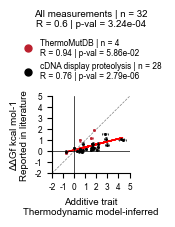

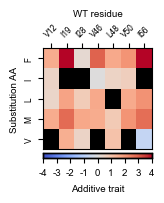

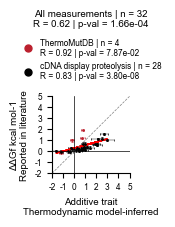

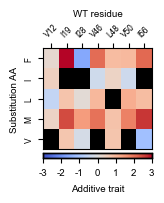

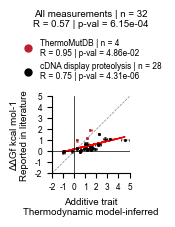

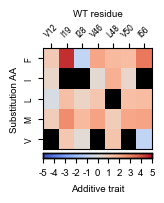

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import math
from matplotlib.patches import Rectangle

plt.rcParams['font.family'] = 'Arial'

model_names = {'order1':'1', 'order2':'2', 'order2_sparse_regularized':'2'}
tasks = {'order1':'1', 'order2':'1', 'order2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+mochi_model+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                           sep='\t')
    coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref =='WT':
            coefs.at[index,'order']=0
        else:
            coefs.at[index,'order']=len(row.id.split('_'))
    
    firstorderterms=coefs.loc[coefs['order']==1].copy()
    
    rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
        left_on='id', right_on='mutations'
    )
    rocklin_merge.set_index('id', inplace=True)
    del rocklin_merge['mutations']
    
    rocklins_wt_dg = -1*rocklin_query_protein.loc[rocklin_query_protein['name']=='3CI2.pdb'].iloc[0]['deltaG']
    rocklins_wt_dg_SE = (-1*rocklin_query_protein.loc[rocklin_query_protein['name']=='3CI2.pdb'].iloc[0]['deltaG_95CI'])/1.96
    alberts_wt_dg = float(coefs.loc[coefs['id']=='WT'].iloc[0]['mean'])
    for index, row in rocklin_merge.iterrows():
        variant_dg_SE = (-1*row.deltaG_95CI)/1.96
        variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2)+(variant_dg_SE**2))
        rocklin_merge.at[index,'rocklin_dGf'] = -1 *row.deltaG
        rocklin_merge.at[index,'rocklin_ddGf'] = (-1 *row.deltaG) - rocklins_wt_dg
        rocklin_merge.at[index,'rocklin_ddGf_SE'] = variant_ddg_SE
        rocklin_merge.at[index,'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
        rocklin_merge.at[index,'albert_dGf'] = alberts_wt_dg + row['mean']
    
#   thermomut_merge = rocklin_merge.merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
#    thermomut_merge = firstorderterms[['id', 'mean', 'std','order']].merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order','PubMed_ID']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    thermomut_merge = firstorderterms[['id', 'mean', 'std','order']].merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    thermomut_avg = pd.DataFrame()
    thermomut_avg["id"] = pd.Series(dtype="object") 
    for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
        multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
        thermomut_avg.at[index,'id']=index
        thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
        thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
        thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
        thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
        thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
    thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
    thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
    thermomut_core['Dataset']='ThermoMutDB'
    rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf':'prev_ddG','rocklin_ddGf_SE':'prev_SE','order':'Nham'})
    rocklin_merge['Dataset']='cDNA display proteolysis'
    all_core_ddGf_validations = pd.concat([thermomut_core[['prev_ddG','prev_SE','mean','std','Dataset','Nham']],rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']]],axis=0)
    
    ## MAKE PLOT ##
    
    
    fig, ax = plt.subplots(figsize=(1, 1))
    palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}
    scatter = sns.scatterplot(
        x='mean', 
        y='prev_ddG', 
        data=all_core_ddGf_validations, 
        hue='Dataset', 
        palette=palette, 
        ax=ax, 
        s=0,
        edgecolor='k', 
        linewidth=0.1
    )
    
    # Error bars
    for dataset in palette.keys():
        plt.errorbar(
            all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['mean'], 
            all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_ddG'], 
            yerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_SE'], 
            xerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['std'], 
            elinewidth=0.3, capsize=1, capthick=0.5, markersize=1, linewidth=0, fmt='o',
            color=palette[dataset], label=''
        )

    # Linear regression for the entire dataset
    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    
    # Plot regression line for the full dataset
    plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
    
    # Calculate correlation for the entire dataset
    r, p = pearsonr(y.ravel(), y_pred.ravel())
    ax.text(
        0.5,2, 
        f'All measurements | n = {len(x)}\nR = {round(r, 2)} | p-val = {p:.2e}', 
        fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
    )
    
    # Axis labels
    plt.xlabel('Additive trait\nThermodynamic model-inferred', fontsize=7)
    plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
    # Adjust ticks and spines
    ax.set_xticks(np.arange(-2, 6, 1))
    ax.set_xticklabels(np.arange(-2, 6, 1), fontsize=6)
    ax.set_yticks(np.arange(-2, 6, 1))
    ax.set_yticklabels(np.arange(-2, 6, 1), fontsize=6)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylim(-0.7,3.5)
    ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'gray',lw=0.5)
    ax.axvline(0,lw=0.5,color='k')
    ax.axhline(0,lw=0.5,color='k')
    ax.set_ylim(-2,5)
    ax.set_xlim(-2,5)
    
    # Subset-specific correlation and legend
    handles, labels = scatter.get_legend_handles_labels()
    legend_labels = []
    for dataset in palette.keys():
        subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
        x_subset = subset[['mean']].to_numpy()
        y_subset = subset[['prev_ddG']].to_numpy()
        model.fit(x_subset, y_subset)
        y_pred_subset = model.predict(x_subset)
        r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
        legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
    custom_markers = [
        Line2D([0], [0], marker='o', color=palette['ThermoMutDB'], markersize=5, linestyle=''),
        Line2D([0], [0], marker='o', color=palette['cDNA display proteolysis'], markersize=5, linestyle='')
    ]
    legend = ax.legend(
        handles=custom_markers,
        labels=legend_labels,
        bbox_to_anchor=(0.5, 1.1),
        loc='lower center',
        fontsize=6,
        frameon=False,
        handletextpad=0.5,
        title='',
        title_fontsize=7
    )
    legend._legend_box.align = "center"


    firstorderterms=all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')].copy()
    
    firstorderterms['mut_from'] = ''
    firstorderterms['mut_from'] = firstorderterms['mut_from'].astype('object')
    firstorderterms['mut_to'] = ''
    firstorderterms['mut_to'] = firstorderterms['mut_to'].astype('object')
    firstorderterms['mut_pos'] = 0
    firstorderterms['mut_pos'] = firstorderterms['mut_pos'].astype(int)
    for index, row in firstorderterms.iterrows():
        firstorderterms.at[index,'mut_from']=index[0:-1]
        firstorderterms.at[index,'mut_to']=index[-1]
        firstorderterms.at[index,'mut_pos']=int(index[1:-1])
    
    firstorderterms=firstorderterms.sort_values(['mut_pos','mut_to'],ascending=[True,True])
    
    real_pos = [2,16,18,24,26,48,53]
    mutated_positions = []
    
    for index, row in firstorderterms.iterrows():
        if index !='WT' and row.mut_from not in mutated_positions:
            mutated_positions.append(row.mut_from)
    
    coefs_hm=pd.DataFrame(columns=mutated_positions)
    
    for index, row in firstorderterms.iterrows():
        if index !='WT':
            coefs_hm.at[row.mut_to,row.mut_from]=row['mean']
    
    fig, ax = plt.subplots(figsize=(1.4,1.6))
    
    #ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*max(coefs_hm.fillna(0).max()), vmax=max(coefs_hm.fillna(0).max()),cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)
    singles_boundary=round(max(all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')]['mean']),0)
    ax=sns.heatmap(coefs_hm.fillna(np.nan), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.03, 'location':'bottom'}, xticklabels=True, yticklabels=True,
                   fmt= '', annot_kws={'size':4})
    ax.figure.axes[-1].set_xticks(ticks=np.arange(-1*round(max(all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')]['mean']),0),round(max(all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')]['mean']),0)+1,1),labels=[int(i) for i in np.arange(-1*round(max(all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')]['mean']),0),round(max(all_core_ddGf_validations[~all_core_ddGf_validations.index.duplicated(keep='first')]['mean']),0)+1,1)], fontsize=7)
    ax.figure.axes[-1].set_xlabel('Additive trait', rotation=0, labelpad=5, fontsize=7)
    plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6, rotation=45)
    plt.xlabel('WT residue',  fontsize=7)
    ax.xaxis.set_label_position('top') 
    plt.ylabel('Substitution AA', fontsize=7)
    ax.spines[['right','top','left','bottom']].set_visible(True)
    #plt.title('Background-averaged\nmutational effects',fontsize=18)
    for spine in ax.figure.axes[-1].spines.values():
        spine.set(visible=True,lw=1,edgecolor='black')
    
    for i in mutated_positions:
        for j in mutated_positions:
            if i[0]==j[0]:
                col=coefs_hm.columns.get_loc(i)
                row=coefs_hm.index.get_loc(j[0])
                ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))

### kcal mol-1 plots

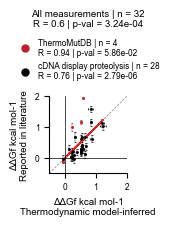

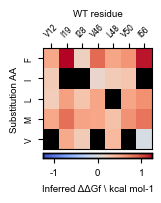

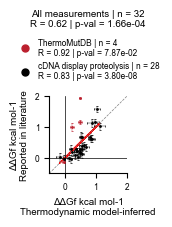

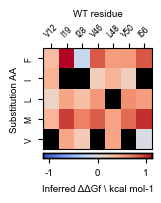

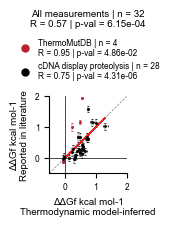

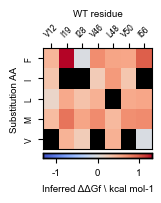

In [18]:
### SCALE VALUES TO MATCH IDENTITY LINE ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import math

plt.rcParams['font.family'] = 'Arial'

model_names = {'order1':'1', 'order2':'2', 'order2_sparse_regularized':'2'}
tasks = {'order1':'1', 'order2':'1', 'order2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+mochi_model+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                               sep='\t')
    coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref == 'WT':
            coefs.at[index, 'order'] = 0
        else:
            coefs.at[index, 'order'] = len(row.id.split('_'))
    
    firstorderterms = coefs.loc[coefs['order'] == 1].copy()
    
    rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
        left_on='id', right_on='mutations'
    )
    rocklin_merge.set_index('id', inplace=True)
    del rocklin_merge['mutations']
    
    rocklins_wt_dg = -1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '3CI2.pdb'].iloc[0]['deltaG']
    rocklins_wt_dg_SE = (-1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '3CI2.pdb'].iloc[0]['deltaG_95CI']) / 1.96
    alberts_wt_dg = float(coefs.loc[coefs['id'] == 'WT'].iloc[0]['mean'])
    for index, row in rocklin_merge.iterrows():
        variant_dg_SE = (-1 * row.deltaG_95CI) / 1.96
        variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2) + (variant_dg_SE**2))
        rocklin_merge.at[index, 'rocklin_dGf'] = -1 * row.deltaG
        rocklin_merge.at[index, 'rocklin_ddGf'] = (-1 * row.deltaG) - rocklins_wt_dg
        rocklin_merge.at[index, 'rocklin_ddGf_SE'] = variant_ddg_SE
        rocklin_merge.at[index, 'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
        rocklin_merge.at[index, 'albert_dGf'] = alberts_wt_dg + row['mean']
    
    thermomut_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG', 'Mut1', 'order']], 
        left_on='id', right_on='Mut1'
    ).drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    thermomut_avg = pd.DataFrame()
    thermomut_avg["id"] = pd.Series(dtype="object") 
    for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
        multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
        thermomut_avg.at[index,'id']=index
        thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
        thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
        thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
        thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
        thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
    thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
    thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
    thermomut_core['Dataset']='ThermoMutDB'
    rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf': 'prev_ddG', 'rocklin_ddGf_SE': 'prev_SE', 'order': 'Nham'})
    rocklin_merge['Dataset'] = 'cDNA display proteolysis'
    all_core_ddGf_validations = pd.concat(
        [thermomut_core[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']],
         rocklin_merge[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']]],
        axis=0
    )
    ## MAKE PLOT ##
    fig, ax = plt.subplots(figsize=(1, 1))
    palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}
    
    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    y_scaled = y
    x_scaled = slope * x + intercept

    model_scaled = LinearRegression()
    model_scaled.fit(x_scaled, y_scaled)
    y_pred_scaled = model_scaled.predict(x_scaled)

    sns.scatterplot(
        x=x_scaled.ravel(),
        y=y_scaled.ravel(),
        hue=all_core_ddGf_validations['Dataset'],
        palette=palette,
        ax=ax,
        s=0,
        edgecolor='k',
        linewidth=0.1
    )

    for dataset in palette.keys():
        mask = all_core_ddGf_validations['Dataset'] == dataset
        plt.errorbar(
            x_scaled[mask].ravel(), 
            y_scaled[mask].ravel(),
            yerr=all_core_ddGf_validations.loc[mask]['prev_SE'], 
            xerr=all_core_ddGf_validations.loc[mask]['std'] * slope,
            fmt='o',
            elinewidth=0.3, 
            capsize=1, 
            capthick=0.5, 
            markersize=1,
            linewidth=0, 
            color=palette[dataset], 
            label=''
        )

    plt.plot(x_scaled, y_pred_scaled, color='red', linewidth=1, linestyle='-')
    ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    r, p = pearsonr(y_scaled.ravel(), y_pred_scaled.ravel())
    ax.text(
        0.5,2, 
        f'All measurements | n = {len(x)}\nR = {round(r, 2)} | p-val = {p:.2e}', 
        fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
    )
    plt.xlabel('ΔΔGf kcal mol-1\nThermodynamic model-inferred', fontsize=7)
    plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_xticklabels(np.arange(0, 3, 1), fontsize=6)
    ax.set_yticks(np.arange(0, 3, 1))
    ax.set_yticklabels(np.arange(-0, 3, 1), fontsize=6)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylim(-0.5,2)
    ax.set_xlim(-0.5,2)

    handles, labels = scatter.get_legend_handles_labels()
    legend_labels = []
    for dataset in palette.keys():
        subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
        x_subset = subset[['mean']].to_numpy()
        y_subset = subset[['prev_ddG']].to_numpy()
        model.fit(x_subset, y_subset)
        y_pred_subset = model.predict(x_subset)
        r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
        legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
    custom_markers = [
        Line2D([0], [0], marker='o', color=palette['ThermoMutDB'], markersize=5, linestyle=''),
        Line2D([0], [0], marker='o', color=palette['cDNA display proteolysis'], markersize=5, linestyle='')
    ]
    legend = ax.legend(
        handles=custom_markers,
        labels=legend_labels,
        bbox_to_anchor=(0.5, 1.1),
        loc='lower center',
        fontsize=6,
        frameon=False,
        handletextpad=0.5,
        title='',
        title_fontsize=7
    )
    legend._legend_box.align = "center"
#    plt.savefig('FYN_ddGs_scaled_from_additivetrait_with_legend_'+mochi_model+'.svg', dpi=300, transparent=True, bbox_inches='tight')
#    plt.savefig('FYN_ddGs_scaled_from_additivetrait_with_legend_'+mochi_model+'.png', dpi=300, transparent=True, bbox_inches='tight')
    all_core_ddGf_validations['actual_ddGs']=x_scaled
    all_core_ddGf_validations['scaled_std']=all_core_ddGf_validations['std'].to_numpy() * slope
    all_core_ddGf_validations.drop_duplicates('actual_ddGs').to_csv(path+'FigS5/CI-2A_ddGs_scaled_from_additivetrait_'+mochi_model+'.txt',sep='\t')

    firstorderterms=all_core_ddGf_validations.drop_duplicates('actual_ddGs').copy()

    firstorderterms['mut_from'] = ''
    firstorderterms['mut_from'] = firstorderterms['mut_from'].astype('object')
    firstorderterms['mut_to'] = ''
    firstorderterms['mut_to'] = firstorderterms['mut_to'].astype('object')
    firstorderterms['mut_pos'] = 0
    firstorderterms['mut_pos'] = firstorderterms['mut_pos'].astype(int)
    for index, row in firstorderterms.iterrows():
        firstorderterms.at[index,'mut_from']=index[0:-1]
        firstorderterms.at[index,'mut_to']=index[-1]
        firstorderterms.at[index,'mut_pos']=int(index[1:-1])
    
    firstorderterms=firstorderterms.sort_values(['mut_pos','mut_to'],ascending=[True,True])
    
    real_pos = [2,16,18,24,26,48,53]
    mutated_positions = []
    
    for index, row in firstorderterms.iterrows():
        if index !='WT' and row.mut_from not in mutated_positions:
            mutated_positions.append(row.mut_from)
    
    coefs_hm=pd.DataFrame(columns=mutated_positions)
    
    for index, row in firstorderterms.iterrows():
        if index !='WT':
            coefs_hm.at[row.mut_to,row.mut_from]=row.actual_ddGs
    
    fig, ax = plt.subplots(figsize=(1.4,1.6))
    
    #ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*max(coefs_hm.fillna(0).max()), vmax=max(coefs_hm.fillna(0).max()),cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)
    singles_boundary=max(all_core_ddGf_validations.drop_duplicates('actual_ddGs')['actual_ddGs'])
    ax=sns.heatmap(coefs_hm.fillna(np.nan), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.03, 'location':'bottom'}, xticklabels=True, yticklabels=True,
                   fmt= '', annot_kws={'size':4})
    ax.figure.axes[-1].set_xticks(ticks=np.arange(-1*round(max(all_core_ddGf_validations.drop_duplicates('actual_ddGs')['actual_ddGs']),0),round(max(all_core_ddGf_validations.drop_duplicates('actual_ddGs')['actual_ddGs']),0)+1,1),labels=[int(i) for i in np.arange(-1*round(max(all_core_ddGf_validations.drop_duplicates('actual_ddGs')['actual_ddGs']),0),round(max(all_core_ddGf_validations.drop_duplicates('actual_ddGs')['actual_ddGs']),0)+1,1)], fontsize=7)
    ax.figure.axes[-1].set_xlabel(r'Inferred ΔΔGf \ kcal mol-1', rotation=0, labelpad=5, fontsize=7)
    plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6, rotation=45)
    plt.xlabel('WT residue',  fontsize=7)
    ax.xaxis.set_label_position('top') 
    plt.ylabel('Substitution AA', fontsize=7)
    ax.spines[['right','top','left','bottom']].set_visible(True)
    #plt.title('Background-averaged\nmutational effects',fontsize=18)
    for spine in ax.figure.axes[-1].spines.values():
        spine.set(visible=True,lw=1,edgecolor='black')
    
    for i in mutated_positions:
        for j in mutated_positions:
            if i[0]==j[0]:
                col=coefs_hm.columns.get_loc(i)
                row=coefs_hm.index.get_loc(j[0])
                ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))
    # Stack the DataFrame
    stacked_df = coefs_hm.stack()
    
    # Create a new DataFrame with mutation names as index
    mutation_df = stacked_df.rename_axis(index=['AA', 'Position']).reset_index()
    mutation_df['Mutation'] = mutation_df['Position'] + mutation_df['AA']
    mutation_df = mutation_df.rename(columns={0: 'ddG'}).set_index('Mutation')[['ddG']]
    mutation_df.merge(all_core_ddGf_validations.drop_duplicates('actual_ddGs')[['scaled_std']],left_index=True,right_index=True).to_csv(path+'FigS7/CI-2A_folding_ivscaled_ddGs_'+mochi_model+'.txt',sep='\t')

## Panel D

### Additive trait plots

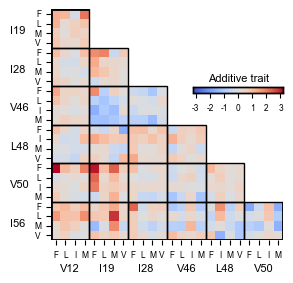

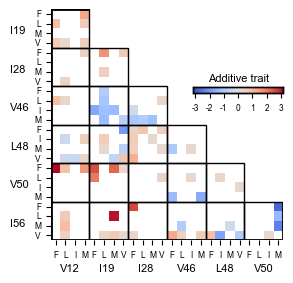

In [19]:
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FuncFormatter

# Define a function to format tick labels
def custom_tick_formatter(x, pos):
    return int(x) if x.is_integer() else x

plt.rcParams['font.family'] = 'Arial'

model_names = {'order2':'2', 'order2_sparse_regularized':'2'}
tasks = {'order2':'1', 'order2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+mochi_model+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                               sep='\t')

    coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref == 'WT':
            coefs.at[index,'order']=0
        else:
            coefs.at[index,'order']=len(row.id.split('_'))
    
    secondorderterms=coefs.loc[coefs['order']==2].copy()
    
    secondorderterms['mutation1']='a'
    secondorderterms['mutation2']='a'
    for index,row in secondorderterms.iterrows():
        secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
        secondorderterms.at[index,'mutation2']=row.id.split('_')[1]
    
    single_mutations=[]
    for index, row in secondorderterms.iterrows():
        if row.mutation1 not in single_mutations:
            single_mutations.append(row.mutation1)
    for index, row in secondorderterms.iterrows():
        if row.mutation2 not in single_mutations:
            single_mutations.append(row.mutation2)    
    
    custom_order = {char: index for index, char in enumerate("FLIMV")}
    
    single_mutations = sorted(
        single_mutations, 
        key=lambda x: (int(''.join(filter(str.isdigit, x[1:]))), custom_order[x[-1]])
    )
    
    pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)
    
    for index, row in secondorderterms.iterrows():
        pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row['mean']
    
    for index, row in secondorderterms.iterrows():
        pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row['mean']
    
    #pairwise_secondorderterms=pairwise_secondorderterms*slope
    pairwise_secondorderterms=pairwise_secondorderterms.fillna(np.nan)
    pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)
    
    fig, ax=plt.subplots(figsize=(3,3))
    for mutation_nr, mutation in enumerate(mutated_positions[1:]):
        plt.text(-4.2, 2.5+4*mutation_nr, mutation, fontsize=8)
    for mutation_nr, mutation in enumerate(mutated_positions[:-1]):
        plt.text(1+4*mutation_nr, 27.2, mutation, fontsize=8)
    
    
    # Create a custom mask
    mask = np.zeros_like(pairwise_secondorderterms.iloc[4:,:-4], dtype=bool)
    for i in range(len(pairwise_secondorderterms.iloc[4:,:-4].index)):
        for j in range(i+1, len(pairwise_secondorderterms.iloc[4:,:-4].index)):  # Only mask rows and columns in the upper diagonal
            if (i // 4) < (j // 4):  # Mask entire quadrants in the upper diagonal
                mask[i, j] = True
    
    
    
    couplings_boundary=pairwise_secondorderterms.fillna(0).values.max()            
    cbar_ax=fig.add_axes([0.6,0.6,0.3,0.02])
    hmap=sns.heatmap(pairwise_secondorderterms.iloc[4:,:-4], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
                  cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-1*round(couplings_boundary * 2)/2,round(couplings_boundary * 2)/2+1,1))}, ax=ax, cbar_ax=cbar_ax, fmt= '', annot_kws={'size':4})
    
    
    #ax.figure.axes[-1].set_ylabel('ddG', rotation=270)
    cbar_ax.set_xlabel('Additive trait', rotation=0, fontsize=8)
    cbar_ax.xaxis.set_label_position('top')
    cbar_ax.xaxis.set_major_formatter(FuncFormatter(custom_tick_formatter))
    for spine in cbar_ax.spines.values():
        spine.set(visible=True,lw=1,edgecolor='black')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
        
    labels_x = [item.get_text() for item in ax.get_xticklabels()]
    for label_nr, label in enumerate(labels_x):
        labels_x[label_nr]=label[-1]
    ax.set_xticklabels(labels_x, rotation=0,fontsize=6)
    labels_y = [item.get_text() for item in ax.get_yticklabels()]
    for label_nr, label in enumerate(labels_y):
        labels_y[label_nr]=label[-1]
    ax.set_yticklabels(labels_y, rotation=0,fontsize=6)
    
    for i in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
        for j in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
            if not np.any(mask[i:i+4, j:j+4]):
                rect = Rectangle((j, i), 4, 4, linewidth=1, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
    
    ax.axhline(y=len(pairwise_secondorderterms.iloc[4:,:-4].index), color='k',linewidth=2)
    ax.axhline(y=0,xmin=0,xmax=0.16, color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=len(pairwise_secondorderterms.iloc[4:,:-4].index),ymin=0,ymax=0.16, color='k',linewidth=2)
            

### kcal mol-1 plots

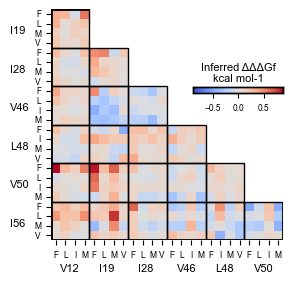

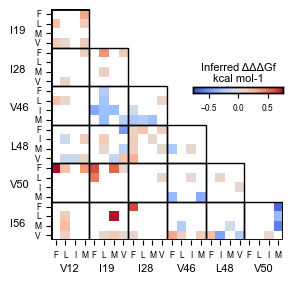

In [20]:
### SCALE VALUES TO MATCH IDENTITY LINE ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import math

plt.rcParams['font.family'] = 'Arial'

model_names = {'order2':'2', 'order2_sparse_regularized':'2'}
tasks = {'order2':'1', 'order2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'FigS4/CI-2A/CI-2A_mochi_'+mochi_model+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                               sep='\t')
    coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref == 'WT':
            coefs.at[index, 'order'] = 0
        else:
            coefs.at[index, 'order'] = len(row.id.split('_'))
    
    firstorderterms = coefs.loc[coefs['order'] == 1].copy()
    
    rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
        left_on='id', right_on='mutations'
    )
    rocklin_merge.set_index('id', inplace=True)
    del rocklin_merge['mutations']
    
    rocklins_wt_dg = -1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '3CI2.pdb'].iloc[0]['deltaG']
    rocklins_wt_dg_SE = (-1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '3CI2.pdb'].iloc[0]['deltaG_95CI']) / 1.96
    alberts_wt_dg = float(coefs.loc[coefs['id'] == 'WT'].iloc[0]['mean'])
    for index, row in rocklin_merge.iterrows():
        variant_dg_SE = (-1 * row.deltaG_95CI) / 1.96
        variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2) + (variant_dg_SE**2))
        rocklin_merge.at[index, 'rocklin_dGf'] = -1 * row.deltaG
        rocklin_merge.at[index, 'rocklin_ddGf'] = (-1 * row.deltaG) - rocklins_wt_dg
        rocklin_merge.at[index, 'rocklin_ddGf_SE'] = variant_ddg_SE
        rocklin_merge.at[index, 'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
        rocklin_merge.at[index, 'albert_dGf'] = alberts_wt_dg + row['mean']
    
    thermomut_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG', 'Mut1', 'order']], 
        left_on='id', right_on='Mut1'
    ).drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    thermomut_avg = pd.DataFrame()
    thermomut_avg["id"] = pd.Series(dtype="object") 
    for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
        multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
        thermomut_avg.at[index,'id']=index
        thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
        thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
        thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
        thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
        thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
    thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
    thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
    thermomut_core['Dataset']='ThermoMutDB'
    rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf': 'prev_ddG', 'rocklin_ddGf_SE': 'prev_SE', 'order': 'Nham'})
    rocklin_merge['Dataset'] = 'cDNA display proteolysis'
    all_core_ddGf_validations = pd.concat(
        [thermomut_core[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']],
         rocklin_merge[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']]],
        axis=0
    )
    
    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    secondorderterms=coefs.loc[coefs['order']==2].copy()

    secondorderterms['mutation1']='a'
    secondorderterms['mutation2']='a'
    for index,row in secondorderterms.iterrows():
        secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
        secondorderterms.at[index,'mutation2']=row.id.split('_')[1]
    
    secondorderterms['scaled_ddGs']=secondorderterms['mean']*slope
    secondorderterms['scaled_ddG_std']=secondorderterms['std']*slope
    
    secondorderterms.to_csv(path+'FigS5/CI-2A_mochi'+mochi_model+'_secondorderterms_scaled_w_iv_values.txt',sep='\t')
    
    
    single_mutations=[]
    for index, row in secondorderterms.iterrows():
        if row.mutation1 not in single_mutations:
            single_mutations.append(row.mutation1)
    for index, row in secondorderterms.iterrows():
        if row.mutation2 not in single_mutations:
            single_mutations.append(row.mutation2)    
    
    custom_order = {char: index for index, char in enumerate("FLIMV")}
    
    single_mutations = sorted(
        single_mutations, 
        key=lambda x: (int(''.join(filter(str.isdigit, x[1:]))), custom_order[x[-1]])
    )
    
    pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)
    
    for index, row in secondorderterms.iterrows():
        pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row['mean']
    
    for index, row in secondorderterms.iterrows():
        pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row['mean']
    
    pairwise_secondorderterms=pairwise_secondorderterms*slope
    pairwise_secondorderterms=pairwise_secondorderterms.fillna(np.nan)
    pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)
    
    fig, ax=plt.subplots(figsize=(3,3))
    for mutation_nr, mutation in enumerate(mutated_positions[1:]):
        plt.text(-4.2, 2.5+4*mutation_nr, mutation, fontsize=8)
    for mutation_nr, mutation in enumerate(mutated_positions[:-1]):
        plt.text(1+4*mutation_nr, 27.2, mutation, fontsize=8)
    
    
    # Create a custom mask
    mask = np.zeros_like(pairwise_secondorderterms.iloc[4:,:-4], dtype=bool)
    for i in range(len(pairwise_secondorderterms.iloc[4:,:-4].index)):
        for j in range(i+1, len(pairwise_secondorderterms.iloc[4:,:-4].index)):  # Only mask rows and columns in the upper diagonal
            if (i // 4) < (j // 4):  # Mask entire quadrants in the upper diagonal
                mask[i, j] = True
    
    
    couplings_boundary=pairwise_secondorderterms.fillna(0).values.max()            
    cbar_ax=fig.add_axes([0.6,0.6,0.3,0.02])
    hmap=sns.heatmap(pairwise_secondorderterms.iloc[4:,:-4], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
                  cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-1*round(couplings_boundary * 2)/2,round(couplings_boundary * 2)/2+1,0.5))}, ax=ax, cbar_ax=cbar_ax, fmt= '', annot_kws={'size':4})
    
    
    #ax.figure.axes[-1].set_ylabel('ddG', rotation=270)
    cbar_ax.set_xlabel('Inferred ΔΔΔGf\nkcal mol-1', rotation=0, fontsize=8)
    cbar_ax.xaxis.set_label_position('top')
    #cbar_ax.xaxis.set_major_formatter(FuncFormatter(custom_tick_formatter))
    for spine in cbar_ax.spines.values():
        spine.set(visible=True,lw=1,edgecolor='black')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
        
    labels_x = [item.get_text() for item in ax.get_xticklabels()]
    for label_nr, label in enumerate(labels_x):
        labels_x[label_nr]=label[-1]
    ax.set_xticklabels(labels_x, rotation=0,fontsize=6)
    labels_y = [item.get_text() for item in ax.get_yticklabels()]
    for label_nr, label in enumerate(labels_y):
        labels_y[label_nr]=label[-1]
    ax.set_yticklabels(labels_y, rotation=0,fontsize=6)
    
    for i in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
        for j in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
            if not np.any(mask[i:i+4, j:j+4]):
                rect = Rectangle((j, i), 4, 4, linewidth=1, edgecolor='black', facecolor='none')
                ax.add_patch(rect)
    
    ax.axhline(y=len(pairwise_secondorderterms.iloc[4:,:-4].index), color='k',linewidth=2)
    ax.axhline(y=0,xmin=0,xmax=0.16, color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=len(pairwise_secondorderterms.iloc[4:,:-4].index),ymin=0,ymax=0.16, color='k',linewidth=2)

    secondorder_coefs = coefs.loc[coefs['order']==2]
    secondorder_coefs=secondorder_coefs.set_index('id')
    secondorder_coefs['dddG']=secondorder_coefs['mean']*slope
    secondorder_coefs['scaled_std']=secondorder_coefs['std']*slope
    secondorder_coefs.to_csv(path+'FigS7/CI-2A_folding_ivscaled_dddGs_'+mochi_model+'.txt',sep='\t')